# Prediction of Airbn prices

### Content
1. **Load and preprocessed data for modeling**
    + load transformed csv file
    + apply correlation analysis
    + split data to train | test | valid with respect do date
2. **Train, validate and save multiple models** (for each category select the best option based on perofrmance on VALIDATION data) 
    + Linear regression
    + Lasso regression
    + RandomForest
    + XGboost
3. **Test best models and select the winner** (evaluation based on performance on TEST data)


## 1. Load and preprocessed data fro modeling

In [1]:
### Dependencies ----------------------------------------------------------------
import pandas as pd # used for working with data sets


###COMBINE ALL .CSVS INTO ONE
file_path = r"..\data\combined.csv"


data = pd.read_csv(file_path)

# Slovník číselníků
num_dict = {
    'Prague-outskirts': 1,
    'Prague-center': 2,
    'Prague': 3
}

# Nový sloupec 'neighb_num' v DataFrame
data['neighb_num'] = data['neighbourhood_cleansed'].map(num_dict)

data.head()


,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,...,review_scores_rating,instant_bookable,host_since_bins,bathrooms_num,bathrooms_shared_bool,year,month,avg_price,date,neighb_num
0,4,1,1,1,0,1,0,Prague-center,Entire home/apt,3,...,5.000000,0,1,1.5,0,2023,6,1396.000000,2023-06-01,2
1,4,1,1,0,1,1,1,Prague-center,Entire home/apt,2,...,4.790000,0,1,1.0,0,2023,6,1645.571429,2023-06-01,2
2,1,0,1,0,0,0,1,Prague-outskirts,Private room,2,...,4.676121,0,1,2.0,0,2023,6,1000.000000,2023-06-01,1
3,2,1,1,0,0,1,1,Prague-center,Entire home/apt,6,...,4.620000,1,1,1.0,0,2023,6,2625.714286,2023-06-01,2
4,4,1,1,1,1,1,1,Prague-center,Entire home/apt,6,...,4.890000,1,1,1.5,0,2023,6,4927.142857,2023-06-01,2


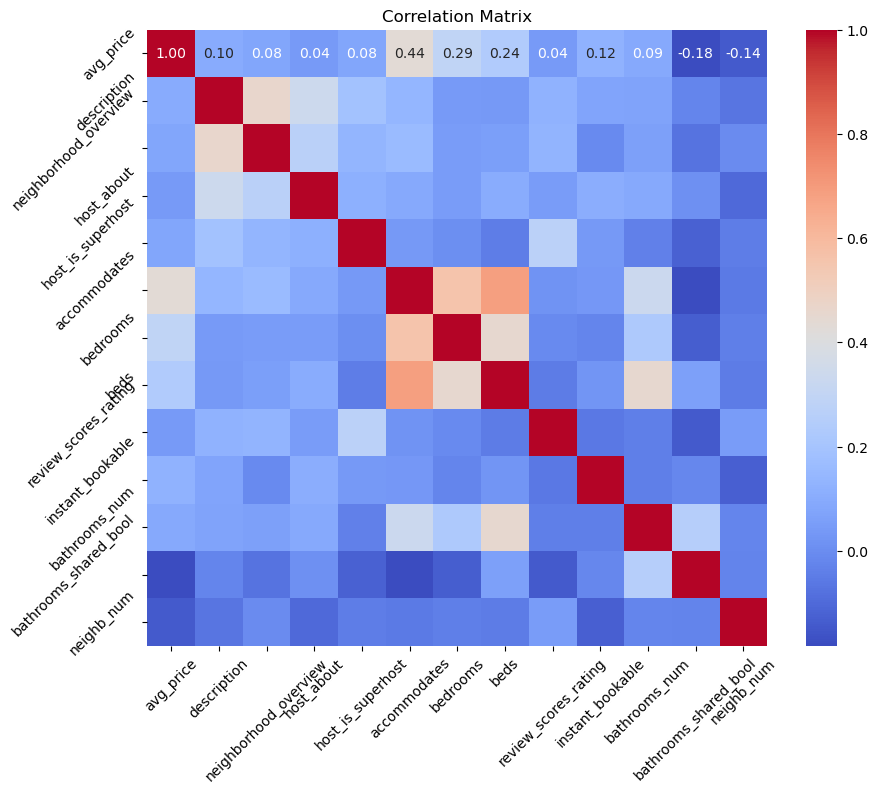

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = ['avg_price','description', 'neighborhood_overview', 'host_about', 'host_is_superhost',
                   'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'instant_bookable',
                   'bathrooms_num', 'bathrooms_shared_bool', 'neighb_num']  

selected_data = data[selected_columns]

correlation_matrix = selected_data.corr(method='pearson')

# Nastavení velikosti obrázku
plt.figure(figsize=(10, 8))

# Vytvoření heatmapy
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Nastavení popisků os
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Zobrazení grafu
plt.show()


In [3]:
# vytvoření dummy proměnných pro regrese

# One-Hot Encoding pro weathercode
neighbourhood_dummies = pd.get_dummies(data['neighbourhood_cleansed'], prefix='neighb-')
room_dummies = pd.get_dummies(data['room_type'], prefix='room-')


# Přidání zakódovaných sloupců zpět do dat
data = pd.concat([data, neighbourhood_dummies], axis=1)
data = pd.concat([data, room_dummies], axis=1)

data.head()

,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,...,avg_price,date,neighb_num,neighb-_Prague,neighb-_Prague-center,neighb-_Prague-outskirts,room-_Entire home/apt,room-_Hotel room,room-_Private room,room-_Shared room
0,4,1,1,1,0,1,0,Prague-center,Entire home/apt,3,...,1396.000000,2023-06-01,2,False,True,False,True,False,False,False
1,4,1,1,0,1,1,1,Prague-center,Entire home/apt,2,...,1645.571429,2023-06-01,2,False,True,False,True,False,False,False
2,1,0,1,0,0,0,1,Prague-outskirts,Private room,2,...,1000.000000,2023-06-01,1,False,False,True,False,False,True,False
3,2,1,1,0,0,1,1,Prague-center,Entire home/apt,6,...,2625.714286,2023-06-01,2,False,True,False,True,False,False,False
4,4,1,1,1,1,1,1,Prague-center,Entire home/apt,6,...,4927.142857,2023-06-01,2,False,True,False,True,False,False,False


## Matice 2 with dummies

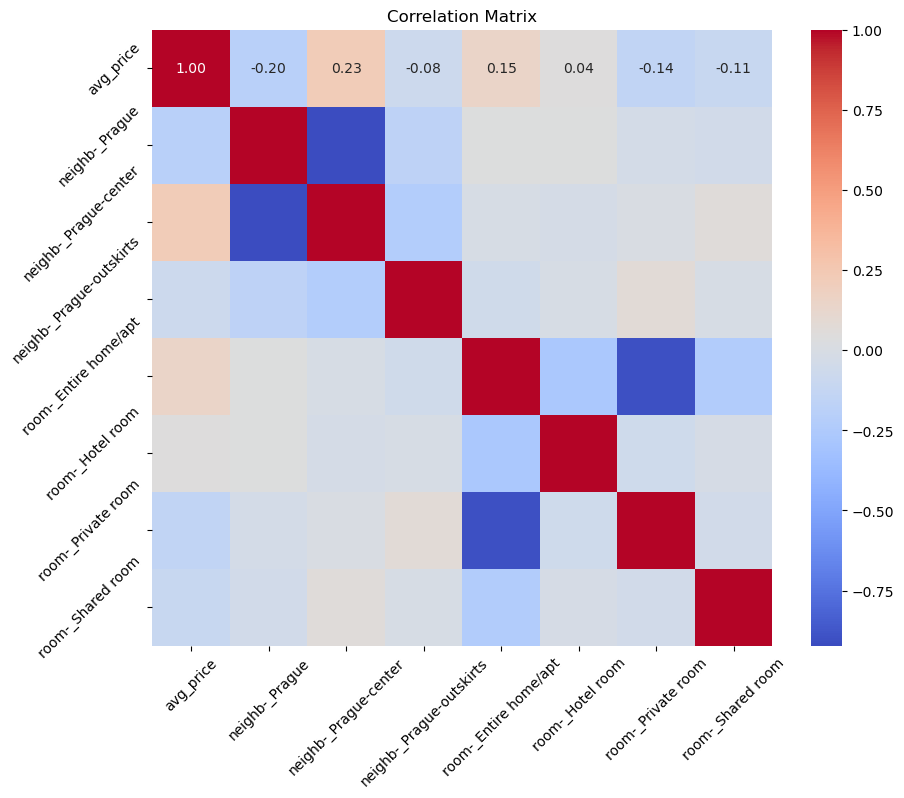

In [5]:
data_corr = data[['avg_price','neighb-_Prague','neighb-_Prague-center', 'neighb-_Prague-outskirts', 'room-_Entire home/apt', 'room-_Hotel room', 'room-_Private room','room-_Shared room']]

correlation_matrix = data_corr.corr(method='pearson')

# Nastavení velikosti obrázku
plt.figure(figsize=(10, 8))

# Vytvoření heatmapy
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Nastavení popisků os
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Zobrazení grafu
plt.show()

### Split - train, test, valid

In [4]:
# sorting data by date
data_sorted = data.sort_values(by='date', ascending=True)
# validation of succesful sorting logic
print(data_sorted['date'])

# setting borders
total_rows = len(data_sorted)
train_idx = int(total_rows * 0.6)
valid_idx = int(total_rows * 0.8)

# train 0 - 60 %
X_train = data_sorted.iloc[:train_idx].drop(['avg_price','neighbourhood_cleansed','room_type','date','neighb_num'], axis=1)
y_train = data_sorted.iloc[:train_idx]['avg_price']

# valid 60 - 80 %
X_valid = data_sorted.iloc[train_idx:valid_idx].drop(['avg_price','neighbourhood_cleansed','room_type','date', 'neighb_num'], axis=1)
y_valid = data_sorted.iloc[train_idx:valid_idx]['avg_price']

# test 80 - 100 %
X_test = data_sorted.iloc[valid_idx:].drop(['avg_price','neighbourhood_cleansed','room_type','date', 'neighb_num'], axis=1)
y_test = data_sorted.iloc[valid_idx:]['avg_price']


0         2023-06-01
5502      2023-06-01
5501      2023-06-01
5500      2023-06-01
5499      2023-06-01
             ...    
131127    2024-09-01
131126    2024-09-01
131125    2024-09-01
131123    2024-09-01
136733    2024-09-01
Name: date, Length: 136734, dtype: object


## 2. Train, validate and save multiple models

Name convention of model abreviations - for labeling RMSE values:

* **LR = Linear regression**
* **LSR = Lasso regression**
* **RF = RandomForest**
* **XGB = XGBoost**

### **Linear regression**

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle


# Fit model to train dataset 
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = model.predict(X_valid)

# Evaluate model on validation dataset
mse = mean_squared_error(y_valid, y_pred)
rmse_LR = mse**(1/2)

# Print the results
print("Intercept:", model.intercept_ )
print("Coefficients:", model.coef_)
print("Mean Squared Error:", mse)  
print("Root Mean Squared Error:",rmse_LR)

# Saving linear regression model as pickle file
with open('../python/models/linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Intercept: -607967.6980889756
Coefficients: [   4.87236388   23.4375712   -86.75716252  -57.72465629  195.20169758
  412.81020135 -914.32358821  403.98835542  209.57805896  -79.93032226
   -2.39646485  205.58077069  245.07784839  -86.75716252   62.02371917
 -506.60826014  300.64209152   39.35366847 -195.58585237  676.73397031
 -481.14811794   55.43051488  637.37773169  107.57305177 -800.38129834]
Mean Squared Error: 5779586.914855466
Root Mean Squared Error: 2404.077144114861


In [ ]:
import matplotlib.pyplot as plt

# Plotting real vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, color='blue', label='Predicted vs Real')
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], '--', color='red', label='Ideal line')
plt.title('Linear Regression: Real vs Predicted')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()


### **Laso regression**

In [6]:
from sklearn.linear_model import Lasso
import pickle


# Set alpha parameter and initialize lasso regression model
alpha = 1  
lasso = Lasso(alpha=alpha)

# Fit model to train dataset
lasso.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred_LAR = lasso.predict(X_valid)

# Evaluating the model on validation dataset
mse = mean_squared_error(y_valid, y_pred_LAR)
rmse_LAR = mse**(1/2)


# Print the results
print("Intercept:", lasso.intercept_)
print("Coefficients:", lasso.coef_)
print("Mean Squared Error:", mse)  
print("Root Mean Squared Error:", rmse_LAR)

# Saving linear regression model as pickle file
with open('../python/models/lasso_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Intercept: -561862.2855465057
Coefficients: [ 5.81979528e+00  1.90351812e+01 -1.69385172e-02 -5.28871569e+01
  1.89527399e+02  3.50699624e+02 -8.85404691e+02  4.06858612e+02
  2.09536565e+02 -8.31687047e+01 -2.39578212e+00  2.01771673e+02
  2.39751624e+02 -1.19756257e+02  5.60572023e+01 -4.89968237e+02
  2.77803593e+02  3.68289181e+01 -0.00000000e+00  8.69259837e+02
 -2.60124629e+02 -1.26601552e+01  5.12991542e+02  2.36280925e+01
 -7.73683286e+02]
Mean Squared Error: 5791218.906250924
Root Mean Squared Error: 2406.495149849865


In [ ]:
import matplotlib.pyplot as plt

# Plotting real vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, color='blue', label='Predicted vs Real')
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], '--', color='red', label='Ideal line')
plt.title('Lasso Regression: Real vs Predicted')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()


### **Random Forest**

In [7]:
### Dependencies
import pandas as pd
import matplotlib.pyplot as plt #basic graphs
import pickle
import time #for timing calculation
import shap
import numpy as np
from tqdm import tqdm

# Usefull functions
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Used models
from sklearn.ensemble import RandomForestRegressor

SEED = 500

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Initial RandomForest

In [122]:
# Initial model with strict parameters
forest_model_0 = RandomForestRegressor(n_estimators=3000,
                                   min_samples_split=10,
                                   max_features = 5,
                                   random_state=SEED)

In [123]:
# Fit RF to the training set
forest_model_0.fit(X_train, y_train.values.ravel()) #values.ravel() flattened array expected by RandomForestRegressor
# Predict the validation set labels 'y_pred'
y_pred= forest_model_0.predict(X_valid)
# Evaluate the validation set RMSE
rmse_RF_0 = mean_squared_error(y_valid, y_pred, squared=False)
print(rmse_RF_0)

1601.522079480112


#### Optimization RandomForest

In [119]:
# Create the  grid with multiple set of parameters
hyper_grid = {'n_estimators': [4000,5000,5500],
               'max_features': [5,9,12],
               'min_samples_split': [10, 20],
               'max_depth' : [None, 5, 10]
               }

# Reinstantiate RandomForestRegressor model
forest_model_cv = RandomForestRegressor()

# Instantiate the GridSearchCV with forest_model_cv  as estimator
grid_search = GridSearchCV(estimator = forest_model_cv, param_grid = hyper_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
#best parameters
print(grid_search.best_params_)
#best estimator
forest_model_opt= grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
{'max_depth': None, 'max_features': 12, 'min_samples_split': 10, 'n_estimators': 4000}


In [9]:
# Predict the validation set labels 'y_pred'
y_pred_cv = forest_model_opt.predict(X_valid)
rmse_RF_opt = mean_squared_error(y_valid, y_pred_cv, squared=False)
print("RMSE for optimized RF by GridSearchCV is: " ,rmse_RF_opt)

RMSE for optimized RF by GridSearchCV is:  1534.0206038931917


#### Saving / Loading RF model

In [130]:
# Sasving RF as pickle file
with open('../python/models/optimized_forest_model.pkl', 'wb') as file:
    pickle.dump(forest_model_opt, file)

In [8]:
model_path = '../python/models/optimized_forest_model.pkl'

# Load the RF model from the file
with open(model_path, 'rb') as file:
    forest_model_opt = pickle.load(file)

#### Explaining optimized RF

**Feature importances**

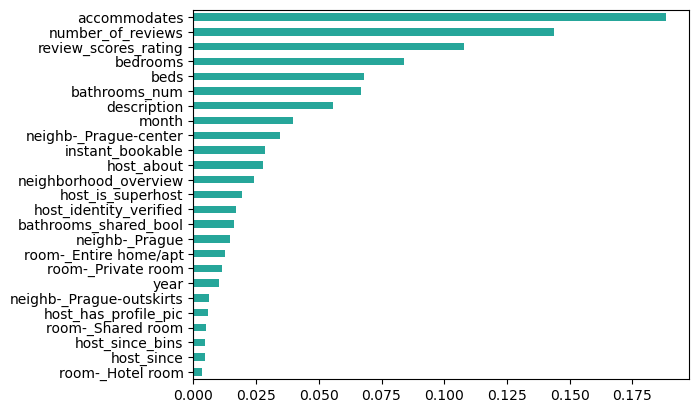

In [7]:
#feature_importances_
importances_rf = pd.Series(forest_model_opt.feature_importances_, index = X_train.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='#26A69A') 
plt.show()

**SHAP values**

Due to very complex RF and computation time it is commented, because it is not the best model

In [6]:
import shap
import numpy as np
from tqdm import tqdm

# # Load your model (assuming it's already loaded as forest_model_opt)
# # Sample 1000 records from the training dataset
# sample_data = X_train.sample(1000, random_state=42)

# # Initialize the SHAP TreeExplainer with your model
# explainer = shap.TreeExplainer(forest_model_opt, n_jobs=-1, model_output="raw", feature_perturbation="interventional")

# # Create a progress bar using tqdm for the SHAP calculation
# shap_values = []
# total = len(sample_data)

# with tqdm(total=total, desc="Computing SHAP Values") as pbar:
#     for start in range(0, total, 100):  # Processing in smaller chunks of 100 for progress updates
#         end = min(start + 100, total)
#         # Compute SHAP values for the current chunk
#         batch_values = explainer.shap_values(sample_data.iloc[start:end])
#         shap_values.append(batch_values)
#         # Update the progress bar
#         pbar.update(end - start)

# # Concatenate SHAP values if they are stored as list of arrays (adjust based on the model output)
# if isinstance(shap_values[0], list):  # Multi-output models
#     shap_values = [np.concatenate([b[i] for b in shap_values], axis=0) for i in range(len(shap_values[0]))]
# else:  # Single output models
#     shap_values = np.concatenate(shap_values, axis=0)

### **XGBoost**

In [4]:
### Dependencies
import xgboost as xgb #pip3 install xgboost
import numpy as np

# Usefull functions
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#### Initial XGBoost

In [9]:
# Initial model with strict parameters
gbm0 = xgb.XGBRegressor(n_estimators = 50, learning_rate = 0.1, objective='reg:squarederror',seed = SEED)

gbm0.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [10]:
# Predict the validation set labels 'y_pred0'
y_pred0 = gbm0.predict(X_valid)

# Evaluate the validation set RMSE
rmse_test0 = mean_squared_error(y_valid, y_pred0, squared=False)
print(rmse_test0)

2208.6979297270473


#### Optimization XGBoost by grid parameters

In [11]:
# setup params grid
param_grid = {'learning_rate': [0.1,0.5,0.9], #alias eta, Step size shrinkage used in update to prevents overfitting.  
    'n_estimators': [20, 50, 100],
    'subsample': [0.5, 0.8, 1], #Subsample ratio of the training instances
    'max_depth': [5, 8, 11],
    'colsample_bytree': [0.5, 1] #colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    }

# instantiate XGBRegressor 
gbm = xgb.XGBRegressor(seed=SEED, objective='reg:squarederror')
grid_mse = GridSearchCV(estimator=gbm,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1)
#fit  GridSearchCV 
grid_mse.fit(X_train, y_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

#extract the estimator best_estimator_ 
xgbm_opt = grid_mse.best_estimator_ 

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 11, 'n_estimators': 100, 'subsample': 1}
Lowest RMSE found:  1287.7731090571547


In [11]:
# Predict the validation set labels 'y_pred'
y_pred = xgbm_opt.predict(X_valid)

# Evaluate the validation set RMSE
rmse_XGB_opt = mean_squared_error(y_valid, y_pred, squared=False)
print("RMSE for optimized XGB by GridSearchCV is: " ,rmse_XGB_opt)

RMSE for optimized XGB by GridSearchCV is:  1468.510373015662


#### Saving / Loading RF model

In [19]:
# Saving optimized XGB model
with open('../python/models/optimized_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgbm_opt, file)

In [10]:
# Loading saved optimized XGB model
# Path to your saved model file
model_path = '../python/models/optimized_xgb_model.pkl'

# Load the model from the file
with open(model_path, 'rb') as file:
    xgbm_opt = pickle.load(file)

#### Explaining optimized XGB

**SHAP values**

In [31]:
##X_sampled = X_train.sample(n=10000, random_state=42)

# Calculating SHAP values on entire X_train set
explainer = shap.TreeExplainer(xgbm_opt, n_jobs = -1)
shap_values = explainer(X_train) 

#### Save / Load SHAP values

In [56]:
with open('../python/models/optimized_xgb_SHAP_values.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

In [7]:
SHAP_values_path = '../python/models/optimized_xgb_SHAP_values.pkl'

# Load the model from the file
with open(SHAP_values_path, 'rb') as file:
    shap_values = pickle.load(file)

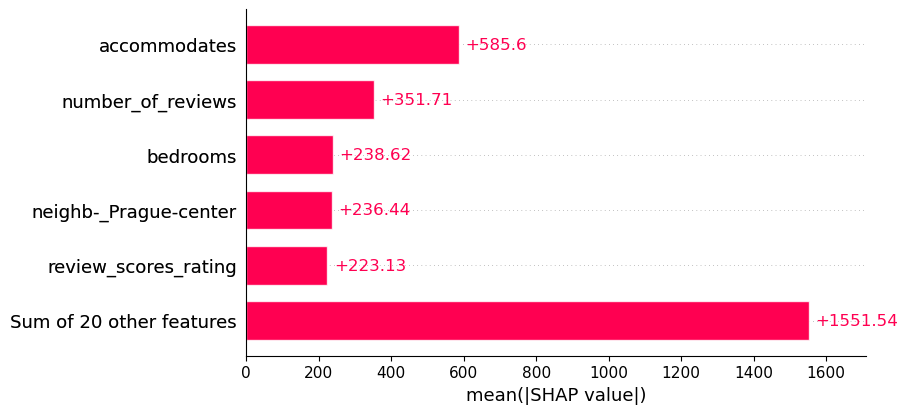

In [8]:
shap.plots.bar(shap_values, max_display=6)

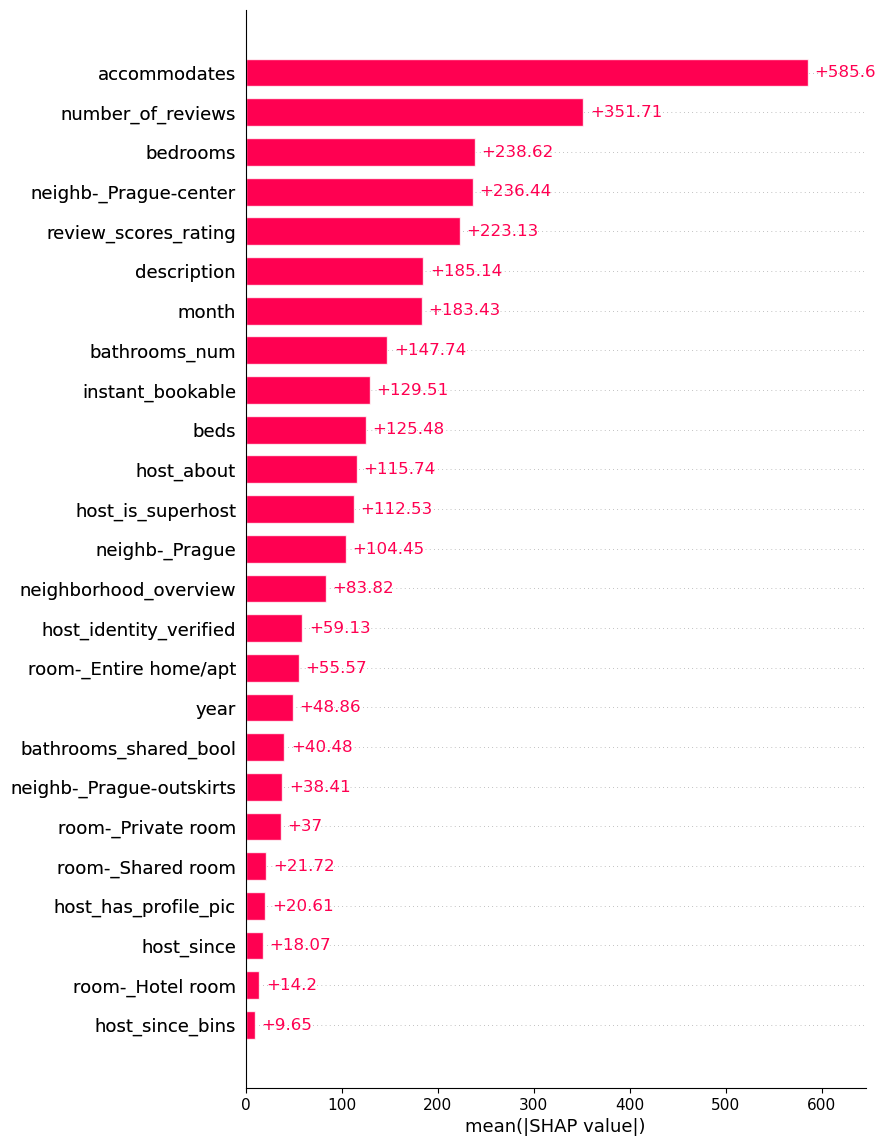

In [72]:
shap.plots.bar(shap_values, max_display=np.shape(shap_values.values)[1])

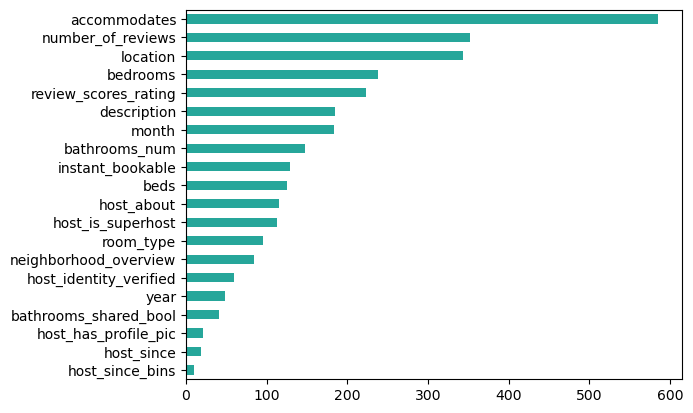

In [63]:
# Handling ONE hot variables

shap_values_pd = pd.DataFrame(shap_values.values, columns=X_train.keys()) #convert into pandas df
shap_values_pd["base_values"] = shap_values.base_values #add expected value
shap_values_pd["location"] = shap_values_pd['neighb-_Prague'] +  shap_values_pd['neighb-_Prague-center'] + shap_values_pd['neighb-_Prague-outskirts']
shap_values_pd["room_type"] = shap_values_pd['room-_Entire home/apt'] +  shap_values_pd['room-_Hotel room'] + shap_values_pd['room-_Private room']+ shap_values_pd['room-_Shared room']

#adjust set of features
X_vars = ['description', 'neighborhood_overview', 'host_since', 'host_about',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'accommodates', 'bedrooms', 'beds', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'host_since_bins',
       'bathrooms_num', 'bathrooms_shared_bool', 'year', 'month', 'location', 'room_type']
shap_importances = shap_values_pd[X_vars].abs().mean() #mean of absolute values
shap_importances = shap_importances.sort_values() 
#plot of variable importance based on shap
shap_importances.plot(kind='barh', color='#26A69A'); plt.show() 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


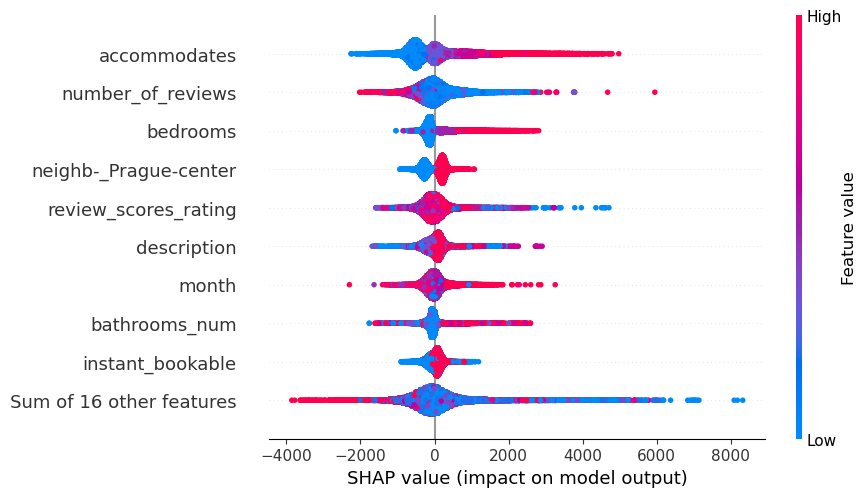

In [79]:
shap.plots.beeswarm(shap_values, max_display=10)

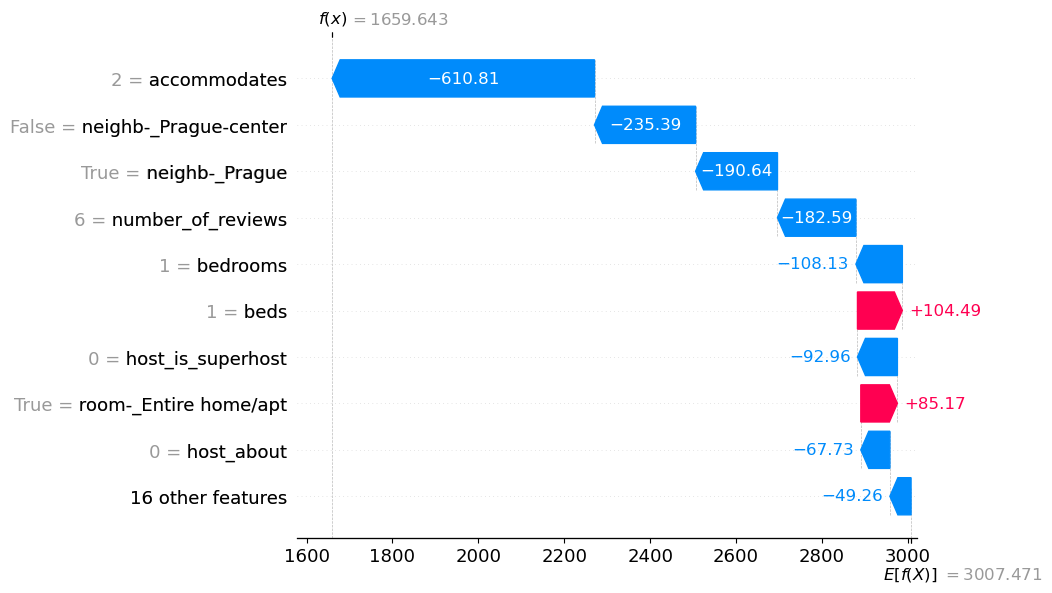

In [20]:
shap.plots.waterfall(shap_values[100])

In [29]:
force_plot_single = shap.plots.force(shap_values[100])

from IPython.display import HTML
HTML(f"<div style='background-color:Lavender;'>{shap.getjs() + force_plot_single.html()}</div>")

In [17]:
shap.initjs()
force_plot = shap.plots.force(shap_values[0:100])

from IPython.display import HTML
HTML(f"<div style='background-color:Lavender;'>{shap.getjs() + force_plot.html()}</div>")

## 2. Test models and select the winner

**Linear Regression test**

In [14]:
y_pred_LR = model.predict(X_test)

rmse_LR_test = mean_squared_error(y_test, y_pred_LR, squared=False)
print(rmse_LR_test)

2481.6321648891694


**Lasso Regression test**

In [15]:
y_pred_LAR = lasso.predict(X_test)

rmse_LAR_test = mean_squared_error(y_test, y_pred_LAR, squared=False)
print(rmse_LAR_test)

2484.007377420247


**RandomForest test**

In [16]:
y_pred_RF = forest_model_opt.predict(X_test)

rmse_RF_test = mean_squared_error(y_test, y_pred_RF, squared=False)
print(rmse_RF_test)

1692.488998318009


**XGBoost tes**

In [17]:
y_pred_XGB = xgbm_opt.predict(X_test)

rmse_XGB_test = mean_squared_error(y_test, y_pred_XGB, squared=False)
print(rmse_XGB_test)

1614.7359516137994


In [28]:
data_model_tests = {
    'Model': ['Linear Regression', 'Lasso Regression', 'RandomForest', 'XGBoost'],
    'RMSE': [rmse_LR_test, rmse_LR_test, rmse_RF_test, rmse_XGB_test]
}

rmse_test_comparison = pd.DataFrame(data_model_tests)


TEST_results_path = '../python/models/optimized_xgb_SHAP_values.pkl'

with open(TEST_results_path, 'wb') as file:
    pickle.dump(rmse_test_comparison, file)

# Load the model from the file
with open(TEST_results_path, 'rb') as file:
    rmse_test_comparison = pickle.load(file)


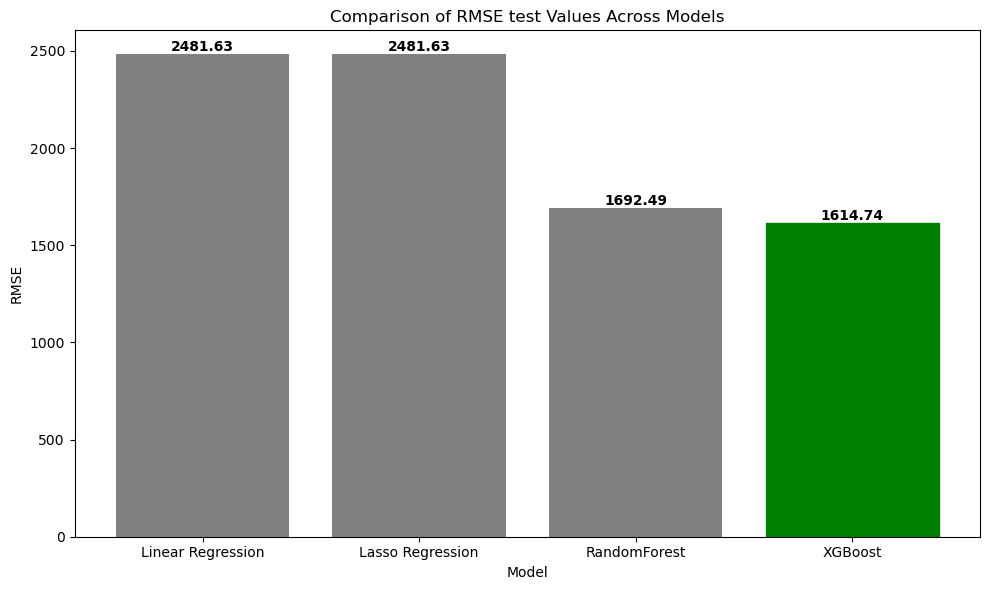

In [30]:
# Find the minimum RMSE value to highlight the corresponding bar
min_rmse = rmse_test_comparison['RMSE'].min()

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_test_comparison['Model'], rmse_test_comparison['RMSE'], color='gray')

# Highlight the bar with the smallest RMSE
for bar, value in zip(bars, rmse_test_comparison['RMSE']):
    if value == min_rmse:
        bar.set_color('green')  # Change color of the min bar
        
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
             ha='center', va='bottom', fontweight='bold')   

# Adding titles and labels
plt.title('Comparison of RMSE test Values Across Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
#plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()